# GRU classifier in keras

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Dense, Flatten, Dropout
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import matplotlib.pyplot as plt # new!
%matplotlib inline

Using TensorFlow backend.


In [2]:
# output directory name:
output_dir = 'model_output/gru'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 10000
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# neural network architecture: 
n_gru = 256
droput_gru = 0.2

#### Load data

For a given data set: 

* the Keras text utilities [here](https://keras.io/preprocessing/text/) quickly preprocess natural language and convert it into an index
* the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [5]:
x_train[:6]

array([[1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
         407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,  256,
           4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
          26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
           4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
         194, 7486,   18,    4,  226,   22,   21,  134,  476,   26,  480,
           5,  144,   30, 5535,   18,   51,   36,   28,  224,   92,   25,
         104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
           5,   16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,
          32],
       [ 163,   11, 3215,    2,    4, 1153,    9,  194,  775,    7, 8255,
           2,  349, 2637,  148,  605,    2, 8003,   15,  123,  125,   68,
           2, 6853,   15,  349,  165, 4362,   98,    5,    4,  228,    9,
          43,    2, 1157,   15,  299,  120,    5,  120,  174,   11,  220,
         175,  136,   5

In [6]:
for i in range(6):
    print len(x_train[i])

100
100
100
100
100
100


#### Design neural network architecture

In [7]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(GRU(n_gru, dropout=droput_gru))
model.add(Dense(1, activation='sigmoid'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 886,785
Trainable params: 886,785
Non-trainable params: 0
_________________________________________________________________


In [9]:
n_dim, n_unique_words, n_dim * n_unique_words

(64, 10000, 640000)

In [10]:
max_review_length, n_dim, n_dim * max_review_length

(100, 64, 6400)

#### Configure Model

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [14]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [15]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
          verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 147s 6ms/step - loss: 0.4953 - acc: 0.7444 - val_loss: 0.3584 - val_acc: 0.8428
Epoch 2/4
25000/25000 [==============================] - 141s 6ms/step - loss: 0.3013 - acc: 0.8754 - val_loss: 0.3537 - val_acc: 0.8469
Epoch 3/4
25000/25000 [==============================] - 189s 8ms/step - loss: 0.2421 - acc: 0.9057 - val_loss: 0.3584 - val_acc: 0.8402
Epoch 4/4
25000/25000 [==============================] - 137s 5ms/step - loss: 0.1992 - acc: 0.9232 - val_loss: 0.3742 - val_acc: 0.8402


#### Evaluate

In [16]:
model.load_weights(output_dir+"/weights.03.hdf5") # zero-indexed

In [17]:
y_hat = model.predict_proba(x_valid)

In [18]:
len(y_hat)

25000

In [19]:
y_hat[0]

array([0.24703994], dtype=float32)

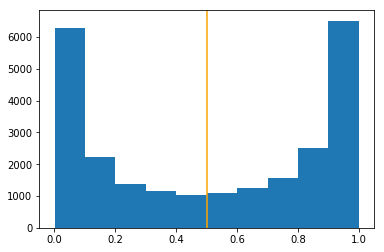

In [20]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [21]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [22]:
"{:0.2f}".format(pct_auc)

'92.10'